# Making Plots from Original images

In [1]:
#### Conda environment
# conda create --name terada2019 python=3.7
# pip install --upgrade pip
# pip install astropy scipy
# pip install photutils
# pip install jupyter matplotlib h5py aplpy pyregion PyAVM healpy
# pip install astroquery

In [2]:
import os
import sys
import time
sys.path
sys.path.append('./')

import numpy as np
from astropy.stats import mad_std

from photutils import datasets
from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture

import aplpy
from astropy.io.fits import getdata
from astropy import wcs
from astropy.io import fits
from astropy import units as u
from astropy import constants as con
from astropy.coordinates import SkyCoord
from astropy.stats import biweight_location, biweight_scale
from scipy.optimize import curve_fit
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

### My own package ##########################
from Classlightcurve import *
#############################################


import matplotlib
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
#%matplotlib inline

## Defining some used mathematical functions

In [ ]:
def gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))



def gaussfit(x, y):
    '''
    Function to perform 1D fitting of Gaussian profile.
    
    Inputs:
    
    X      [numpy array]  : X coordiates
    Y      [numpy array]  : Y values
    
    Return:
    popt   [float list]   : [amplitude, centroid-X, and sigma]
    '''
    mean  = sum(x * y) / sum(y)
    sigma = np.sqrt(sum( abs(y) * ( (x - mean)**2 ) ) / sum(y) )
    
    # initial guess
    p0    = [max(y), mean, sigma]
    try:
        popt, pcov = curve_fit(gauss, x, y, p0=p0)
    except:
        print('Warning. Failed fitting Gaussian profile.')
        popt = [0.0,0.0,0.0]
    
    return popt



def angoff_degree(coord1, coord2):
    '''
    A function to evaluate angular offset (in degree units).
    This function assumes that the declinations of the two sources
    are not very different.
    
    Inputs:
    coord1,2   [lists of float]  : [ra, dec] in degree unit.
    
    Return:
    Angular offset in degree unit [float].
    '''
    
    dec_off  =  coord1[1] - coord2[1]
    mean_dec = (coord1[1] + coord2[1]) / 2.0
    ra_off   = ( coord1[0] - coord2[0] ) * \
                 np.cos( mean_dec * (np.pi/180.0) )
    
    off      = np.sqrt( ra_off**2.0 + dec_off**2.0 )
    return off

#### Format of marker file:

name, ra_h ra_m ra_s dec_d dec_m dec_s  R:0-1 G:0-1 B:0-1 alpha  size

dm_tau  04 33 48.7335659850  +18 10 09.974471722  1 0.2 0.2 1.0 2.0

#### Format of reference star file

name, ra dec R:0-1 G:0-1 B:0-1 alpha size band jd count file_name

1_8 68.61225456763495 18.265153228501678 1 0 1 1 30 I 2458491.56799249 82873.91795331985 dm tau_3463766_I_015.fits

1_10 68.58791728147689 18.313321866312478 1 0 1 1 30 I 2458491.56799249 157532.68915795215 dm tau_3463766_I_015.fits

1_12 68.55803592095405 18.35926561721569 1 0 1 1 30 I 2458491.56799249 77123.45560573619 dm tau_3463766_I_015.fits


## Defining a aperture photometry pipeline class

### Recommended strategy of running this pipeline:

1. First produce preview images for all images, and then produce a skip_file_lis after visual inspect.

2. Run the rest of the procedures, incorporating skip_file_lis to save time and avoid crashing DAOstarfinder and photoutils

In [ ]:
class marker:
    '''
    Class for marker objects.
    
    It can also be used as objects to store information about aperture photometry,
    using the attributes :
    

    band_list [list of string] : Recording the information of used bands.
    
    jd_dict   [dictory of (list of double), key: band] : to store jd dates for
                                                         measurements at certain bands.
    
    flux_dict [dictory of (list of double), key: band] : to store fluxes (or counts) for
                                                         measurements at certain bands
                                                         
    mag_dict [dictory of (list of double), key: band] : to store magnitudes for
                                                         measurements at certain bands
    '''
    
    def __init__(self, label='unknown_marker'):
        self.label = label
        self.ra    = 0.0
        self.dec   = 0.0
        self.color = (0,0,0)
        self.alpha = 1.0
        self.size  = 1.0
        
        self.band_list   = []
        self.jd_dict     = {}
        self.flux_dict   = {}
        self.mag_dict    = {}
        self.magerr_dict = {}
    
    def __del__(self):
        pass
        
        

class apt_pipe:
    '''
    Class for apeture photometry pipeline.
    
    History:
    1. Basic version developed.  (Baobab Liu, 2019, Dec.07)
    
    2 Required Conda enviornment:
    # conda create --name terada2019 python=3.7
    # pip install --upgrade pip
    # pip install astropy scipy
    # pip install photutils
    # pip install jupyter matplotlib h5py aplpy pyregion PyAVM healpy
    
    '''

    
    def __init__(self, data_path = './',
                 markerfile   = './markers.txt',
                 ascii_report = './ascii_report.txt',
                 verbose      = False
                ):
        '''
        Initializer of the class.
        It first load image names from the FITS image directory.
        Then it checks the integrity of the FITS image headers,
        and dump report to an ASCII file.
        Finally, it loads the coordinate of the markerfile if any.
        
        
        
        Keywords:
        
        data_path [string] or list of [string] : Default: './'.
                  Can either load data from one specified directory or a list of 
                  specified directory.
        
        markerfile [string]   : File name of one or a list of markers.
                  Format :
                  name, ra_h ra_m ra_s dec_d dec_m dec_s R:0-1 G:0-1 B:0-1 alpha size
                  Example :
                      dm_tau  04 33 48.7335659850 +18 10 09.974471722   1 0.2 0.2 1.0 2.0
                      test    04 33 48.7335659850  +18 10 49.974471722  0.0 1.0 0 1.0 30.0
        
        ascii_report [string] :
        
        verbose   [True]      : Verbosely dump the status of the data.
        
        
        
        Methods:
        
        plot_preview          : Plotting preview figures for FITS images under the data_path(s)
        
        do_apt                : Do aperture photometry for loaded marker(s).
        
        
        '''
                                        
        self.data_path  = data_path
        self.markerfile = markerfile
        self.verbose    = verbose
        self.num_images = 0
        self.num_markers = 0
        self.ascii_report = ascii_report
        
        # initialize variables
        os.system('rm -rf ' + ascii_report)
        F_report = open(ascii_report,"w+")
        self.data_path_list  = []
        self.num_data_path   = 0
        self.filterlist      = []
        self.images          = []
        self.path_dict       = {}
        self.band_dict       = {}
        self.date_dict       = {}
        self.jd_dict         = {}
        self.countrange_dict = {} # storing [max(count), min(count)] for individual image_name
        self.fwhm_dict       = {}
        self.marker_list     = []
        
        # load image names
        if ( type(data_path) == str ):
            self.data_path_list.append(data_path)
            self.num_data_path = 1
            if (verbose==True):
                print('Loading FITS image from single directory : ' + data_path)
                
        if ( type(data_path) == list ):
            self.data_path_list.extend(data_path)
            self.num_data_path = len( self.data_path_list )
            if (verbose==True):
                for data_idx in range(0, len(data_path) ):
                    print('Loading FITS image from : ' + data_path[data_idx])
                            
        try:
            for data_idx in range(0, self.num_data_path):
                self.images.extend(  os.listdir( self.data_path_list[data_idx] )  )
                temp_names = os.listdir( self.data_path_list[data_idx] )
                # self.num_images = self.num_images + len( temp_names )
                for name in temp_names:
                    self.path_dict[name] = self.data_path_list[data_idx]
            self.num_images = len( self.images )
                
            if ( verbose == True ):
                print('##############################################################')
                print('Processing ' + str(self.num_images).strip() + ' images \n')
                print('##############################################################')
        except:
            print('No image found')
            
            
        # checking integrity of FITS headers
        F_report.write('FITS header integrity: \n')
        for i in range(0, self.num_images):
            
            image_name = self.images[i]
            hdulist = fits.open( self.path_dict[image_name] + '/' + image_name)
            try:
                crval1 = hdulist[0].header['crval1']
                crval2 = hdulist[0].header['crval2']
            except:
                if (verbose == True ):
                    print('Warning, coordinate header of ' + image_name + ' does not exist.')
                F_report.write( image_name + ' has no coordinate header \n' )
                continue
                
            try:
                date   = hdulist[0].header['date-obs']
                jd     = hdulist[0].header['jd']
                self.date_dict[image_name] = date
                self.jd_dict[image_name]  = jd
            except:
                if (verbose == True ):
                    print('Warning. Observing date of ' + image_name + ' is not known.')
                F_report.write( image_name + ' has no observing time information \n' )
                continue
                
            try:
                band   = hdulist[0].header['filter']
                if (band not in self.filterlist):
                    self.filterlist.append(band)
                self.band_dict[image_name] = band
            except:
                if (verbose == True ):
                    print('Warning. Filter name of ' + image_name + ' does not exist.')
                F_report.write( image_name + ' has unknown filter band. \n' )
                continue
                
        F_report.write('\n')
        
        # load markers if there is
        try:
            marker_label     = np.loadtxt(markerfile, comments='#', skiprows=0, usecols=0, dtype=np.str)
            rah              = np.loadtxt(markerfile, comments='#', skiprows=0, usecols=1 )
            ram              = np.loadtxt(markerfile, comments='#', skiprows=0, usecols=2 )
            ras              = np.loadtxt(markerfile, comments='#', skiprows=0, usecols=3 )
            decd             = np.loadtxt(markerfile, comments='#', skiprows=0, usecols=4 )
            decm             = np.loadtxt(markerfile, comments='#', skiprows=0, usecols=5 )
            decs             = np.loadtxt(markerfile, comments='#', skiprows=0, usecols=6 )
            markerR          = np.loadtxt(markerfile, comments='#', skiprows=0, usecols=7 )
            markerG          = np.loadtxt(markerfile, comments='#', skiprows=0, usecols=8 )
            markerB          = np.loadtxt(markerfile, comments='#', skiprows=0, usecols=9 )
            marker_alpha     = np.loadtxt(markerfile, comments='#', skiprows=0, usecols=10)
            marker_size      = np.loadtxt(markerfile, comments='#', skiprows=0, usecols=11)
                        
            ra  = ( rah + ram / 60.0 + ras / 3600.0 ) * 15.0
            dec_sign = np.where( (decd>0), 1.0, -1.0)
            dec      = decd + dec_sign * decm / 60.0 + dec_sign * decs / 3600.0
                
            self.num_markers = np.size(ra)
            if (verbose == True):
                print('Number of markers : ' + str(self.num_markers).strip() )
                
            # loading to marker objects
            for mid in range(0, self.num_markers):
                if (self.num_markers > 1):
                    temp_marker       = marker(label=marker_label[mid])
                    temp_marker.ra    = ra[mid] 
                    temp_marker.dec   = dec[mid]
                    temp_marker.color = (markerR[mid], markerG[mid], markerB[mid])
                    temp_marker.alpha = (marker_alpha[mid])
                    temp_marker.size  = (marker_size[mid])
                    self.marker_list.append(temp_marker)
                else:
                    temp_marker       = marker(label=marker_label)
                    temp_marker.ra    = ra
                    temp_marker.dec   = dec
                    temp_marker.color = (markerR, markerG, markerB)
                    temp_marker.alpha = (marker_alpha)
                    temp_marker.size  = (marker_size)
                    self.marker_list.append(temp_marker)
            
        except:
            if (verbose == True):
                print('No markers loaded')

        # Dumping more information ot the report
        # filters
        F_report.write('Used filters: \n')
        outstring = ' '
        for tempstr in self.filterlist:
            outstring = outstring + tempstr + ' '
        F_report.write(outstring + '\n')
        
        F_report.close()

        
        
    def __del__(self):
        pass
    
    
    
    ''' 
    #####################################################################################
    FUNCTION
    #####################################################################################
    '''    
    
    def background_sub(self, image, option='median'):
        '''
        Function to subtract background from a image.
        
        
        Keyword :
        
           option [str]  :
              median : subtracting the median value from an image (Default)
        
        
        Return  :
           Background subtracted image
           
        '''
        
        if ( option == 'median' ):
            image = image - np.median(image) 
        
        return image
    
    
    
    def get_fwhm(self, image, wcs, ra, dec, 
                 background_sub_option,
                 naxis1, naxis2, cropbox_halfsize_x, cropbox_halfsize_y
                ):
        '''
        From a given image with wcs object (astropy), perform Gaussian fittings to obtain
        the fwhm of the point spread function.
        The present version fits fwhm in horizontal and vertical directions,
        and then return the larger one.
        
        Inputs :
        
        image    [numpy array]     : An input 2D image.
        
        wcs      [astropy wcs]     : An astropy wcs object constructed from the FITS image header.
        
        ra       [float]           : R.A. in degree unit.
        
        dec      [float]           : Decl. in degree unit.
        
        fwhm     [float]           : full width at half maximum of the point spread function.
        
        background_sub_option [str]: Keyword to specify how background subtraction is made.
                                     See description in function: background_sub.
        
        naxis1,2   [int]           : Dimension of the input image.
        
        cropbox_halfsize_x,y [int] : Size of the cropped image to measure aperture photometry from,
                                     in pixel unit.
        
        
        Return :
        
        fwhm    [float]           : aperture photometry measurement in image flux/pixel unit.
        '''
        
        fwhm1 = 0.0
        fwhm2 = 0.0
        
        # load pixel coordinates
        pixcrd2 = wcs.wcs_world2pix([ [ra,dec] ], 0)
        xpix = pixcrd2[0][0]
        ypix = pixcrd2[0][1]
        xpix_min = int(round(xpix - cropbox_halfsize_x) )
        xpix_max = int(round(xpix + cropbox_halfsize_x) )
        ypix_min = int(round(ypix - cropbox_halfsize_y) )
        ypix_max = int(round(ypix + cropbox_halfsize_y) )

        if (xpix_min < 0): xpix_min = 0
        if (ypix_min < 0): ypix_min = 0
        if (xpix_max > (naxis1-1) ): xpix_max = (naxis1-1)
        if (ypix_max > (naxis2-1) ): ypix_max = (naxis2-1)

        # crop the image to speed up the source finding
        crop = image[ypix_min:(ypix_max+1), xpix_min:(xpix_max+1)].astype(float)

        # do background subtraction from the crop
        crop = self.background_sub(crop, option=background_sub_option)
        
        naxis1 = xpix_max - xpix_min + 1
        naxis2 = ypix_max - ypix_min + 1
        
        # do fitting in axis1
        x_array = np.arange(0, naxis1, 1)
        if ( (naxis2 % 2) == 1 ):
            y_array = crop[ int( (naxis2-1)/2), :]
        else:
            y_array = ( crop[ int( (naxis2)/2 ), :] + crop[ int( (naxis2-2)/2 ), :] ) / 2.0
        index = ~(np.isnan(x_array) | np.isnan(y_array))
        parms = gaussfit(x_array[index], y_array[index])
        fwhm1 = parms[2] * 2.35
        
        # do fitting in axis2
        x_array = np.arange(0, naxis2, 1)
        if ( (naxis1 % 2) == 1 ):
            y_array = crop[:, int( (naxis1-1)/2) ]
        else:
            y_array = ( crop[:, int( (naxis1)/2 ) ] + crop[:, int( (naxis1-2)/2 ) ] ) / 2.0
        index = ~(np.isnan(x_array) | np.isnan(y_array))
        parms = gaussfit(x_array[index], y_array[index])      
        fwhm2 = parms[2] * 2.35
        
        fwhmlist = []
        for value in [fwhm1, fwhm2]:
            if (np.isfinite(value) == True):
                if (value > 0):
                    fwhmlist.append(value)
                    
        if ( len(fwhmlist) > 0 ):
            fwhm = np.max(fwhmlist)
        else:
            fwhm = 0.0
        
        return fwhm
    
    
    
    def get_count(self, image, wcs, ra, dec, fwhm, 
                  background_sub_option, apt_sigmathreshold,
                  naxis1, naxis2, cropbox_halfsize_x, cropbox_halfsize_y):
        '''
        From a given image with wcs object (astropy), 
        using aperture photometry to measure counts of a specific star around the location 
        ra and dec, assuming a certain fwhm for the PSF
        
        Inputs :
        
        image    [numpy array]     : An input 2D image.
        
        wcs      [astropy wcs]     : An astropy wcs object constructed from the FITS image header.
        
        ra       [float]           : R.A. in degree unit.
        
        dec      [float]           : Decl. in degree unit.
        
        fwhm     [float]           : full width at half maximum of the point spread function.
        
        background_sub_option [str]: Keyword to specify how background subtraction is made.
                                     See description in function: background_sub.
                                     
        apt_sigmathreshold [float] : Identify stars which are brighter than the specified
                                        sigma threshold.
        
        naxis1,2   [int]           : Dimension of the input image.
        
        cropbox_halfsize_x,y [int] : Size of the cropped image to measure aperture photometry from,
                                     in pixel unit.
        
        
        Return :
        
        count    [float]           : aperture photometry measurement in image flux/pixel unit.
        
        '''

        # Initializing the mearurement
        count = 0
        
        # load pixel coordinates
        pixcrd2 = wcs.wcs_world2pix([ [ra,dec] ], 0)
        xpix = pixcrd2[0][0]
        ypix = pixcrd2[0][1]
        xpix_min = int(round(xpix - cropbox_halfsize_x) )
        xpix_max = int(round(xpix + cropbox_halfsize_x) )
        ypix_min = int(round(ypix - cropbox_halfsize_y) )
        ypix_max = int(round(ypix + cropbox_halfsize_y) )

        if (xpix_min < 0): xpix_min = 0
        if (ypix_min < 0): ypix_min = 0
        if (xpix_max > (naxis1-1) ): xpix_max = (naxis1-1)
        if (ypix_max > (naxis2-1) ): ypix_max = (naxis2-1)

        # crop the image to speed up the source finding
        crop = image[ypix_min:(ypix_max+1), xpix_min:(xpix_max+1)].astype(float)

        # do background subtraction from the crop
        crop = self.background_sub(crop, option=background_sub_option)

        # estimate robust standard deviation from the cropped image
        bkg_sigma = mad_std(crop)

        # find stars
        daofind = DAOStarFinder(fwhm=fwhm, threshold=apt_sigmathreshold*bkg_sigma)
        sources = daofind(crop)
        try:
            mxcentroid_array = np.array( sources['xcentroid'] )
            mycentroid_array = np.array( sources['ycentroid'] )
            mpeak_array      = np.array( sources['peak']      )
            num_sources      = len(mpeak_array)
        except:
            num_sources      = 0

        # Outputting measurements
        if ( num_sources > 0 ):
            sortidx    = np.argsort(mpeak_array)
            maxidx     = sortidx[-1]
            mxcentroid = mxcentroid_array[maxidx]
            mycentroid = mycentroid_array[maxidx]
            positions = np.transpose((mxcentroid, mycentroid))
            apertures = CircularAperture(positions, fwhm*2.0)
            phot_table = aperture_photometry(crop, apertures)
            count     = phot_table['aperture_sum'][0]
               
        return count
    
    
    ''' 
    #####################################################################################
    METHOD
    #####################################################################################
    '''    
            
    def find_ref(self, refimg_list=[], countrange=[0.0, 0.0],
                crop_size=1.0/30.0,
                background_sub_option = 'median',
                apt_sigmathreshold    = 5.0,
                fit_fwhm              = True,
                fwhm                  = 0.0,
                refstar_file          = 'reference_star.txt',
                 refstar_color        = (1, 0, 1),
                 refstar_symsize      = 30,
                skip_file_list        = []
                ):
        '''
        Method to find reference stars.
        It looks for stars in a list of images, excluding those which are brighter or dimmer
        than the specified countrange, further excluding those which are already in the 
        markers_list (i.e., those separated from markers by less than one PSF-fwhm),
        and then either store to ASCII output,
        which can be loaded by the cal_ref method.
        
        
        Keywords :
        
        refimg_list   [str list]   : A list of image path+name for identifying reference stars.
                                     Will use all images if this is not specified.
                                    
        countrange    [float list] : [count_min, count_max], in image brightness unit. If set,
                                     then only use reference stars of which the counts are within
                                     the specified range. Otherwise, if 
                                     (i) refimg_list is specified, will use all found stars
                                         (except those in the input marker list).
                                     (ii) refimg_list is not specified. In this case, if the 
                                          countrange_dict for individual images have been evaluated 
                                          by a preliminary run of do_apt and were stored, then we 
                                          will use the stored values. It is presently defined as
                                          [
                                           self.countrange_dict{image_name}[0]/2.5, 
                                           self.countrange_dict{image_name}[0]*2.5
                                          ], i.e., using reference stars in approximately +/1 mag
                                          range as compared with all target sources.
                                          Otherwise, will use all found
                                          stars (except those in the input marker list).
                                          
        crop_size      [float] : size of the crops for making aperture photometry.
                                 Default is 1/30 of the entire image. Need to enlarge the crop
                                 if the size is smaller than two times the fwhm (see the fwhm item).
                                          
        background_sub_option [str]: Keyword to specify how background subtraction is made.
                                     See description in function: background_sub.
                                     
        apt_sigmathreshold    [float] : Identify stars which are brighter than the specified
                                        sigma threshold. Default: 5-sigma.

        fit_fwhm         [True/False] : Specify whether or not we will fit fwhm from reference
                                        stars. If not, will use the specified fwhm 
                                        (see the fwhm item).
                                        If true, and if fwhm is set to 0.0, then we will use the
                                        fwhm derived from the preliminary run of do_apt when finding
                                        candidate reference stars.
                                        
        fwhm                  [float] : fwhm of the point-spread-function in units of pixels.
                                        If fit_fwhm=False, then this parameter has to be specified.
                                        Otherwise, this method will imply report error.
                                        If fit_fwhm=True, this fwhm will be used only during initial 
                                        search of potential sources.
                                        
        refstar_file          [str]   : Filename to ASCII output the identified reference stars.
        
        skip_file_list  [list of str] : A list of filename that we do not want to find reference stars
                                        from, for example, for some epochs which the PSFs are not round.
                                        This helps since the phoutils package is very slow when examining
                                        such images. And such images are not useful anyway.
        '''
        
        ##### Initial preparation - - - - - - - - - - - - - - - - - - - - - 
        
        from_input_list = True
        
        
        F_report = open(self.ascii_report,"a+")
        F_report.write('\n')
        F_report.write('Finding reference stars: \n')
        F_report.write('(only FITS images with compte header information are processed.) \n')
        
        F_refstar = open(refstar_file,"w+")
        F_refstar.write("# name, ra dec R:0-1 G:0-1 B:0-1 alpha size band jd count file_name \n")
        
        
        if (fit_fwhm == False):
            if (fwhm == 0.0):
                print('No way to determine fwhm. Return.')
                F_report.write('No way to determine fwhm. Returned. \n')
                F_report.close()
                return
        
        if ( len(refimg_list) == 0 ):
            from_input_list = False
            if (self.verbose == True):
                print("No input reference image names. Searching for reference stars from all input images.")
            
            for i in range(0, self.num_images):
                image_name  = self.images[i]
                dirstr     = self.path_dict[image_name] + '/' + image_name
                refimg_list.append(dirstr)
                
                
        for file_id in range(0, self.num_images):

            ##### Identifying reference stars - - - - - - - - - - - - - - - - - - - - - 
            
            # loading image_name in case we need to refer to dictionaries
            if (from_input_list == False):
                image_name = self.images[file_id]
                
                if (image_name in skip_file_list):
                    F_report.write('Excluding ' + image_name + ' because it is in the skip list \n')
                    continue
                
                if (self.verbose == True):
                    print('######## Finding references from image : ' + image_name)
                try:
                    band = self.band_dict[image_name]
                    jd   = self.jd_dict[image_name]
                except:
                    continue
            
            # open FITS image
            try:
                hdulist = fits.open( refimg_list[file_id] )
            except:
                F_report.write('Failed to open image : ' + image_name + '\n')
                continue
                
            # load header information
            try:
                image   = hdulist[0].data
                image   = np.array(image)
                naxis1  = hdulist[0].header['naxis1']
                naxis2  = hdulist[0].header['naxis2']
                pixsize = hdulist[0].header['secpix']
                crval1  = hdulist[0].header['crval1']
                crval2  = hdulist[0].header['crval2']
                w       = wcs.WCS(hdulist[0].header)
                cropbox_halfsize_x = int((float(naxis1)/2.0) * crop_size)
                cropbox_halfsize_y = int((float(naxis2)/2.0) * crop_size)
            except:
                F_report.write('Failed to load wcs for image : ' + image_name + '\n')
                continue
                
            # do background subtraction from the crop
            image = self.background_sub(image, option=background_sub_option)

            # estimate robust standard deviation from the cropped image
            bkg_sigma = mad_std(image)

            # find stars
            if (fit_fwhm==True):
                try:
                    findstar_fwhm = self.fwhm_dict[image_name]
                except:
                    findstar_fwhm = 0.0
            else:
                findstar_fwhm=fwhm
            
            daofind = DAOStarFinder(fwhm=findstar_fwhm, threshold=apt_sigmathreshold*bkg_sigma)
            sources = daofind(image)
            try:
                mxcentroid_array = np.array( sources['xcentroid'] )
                mycentroid_array = np.array( sources['ycentroid'] )
                mpeak_array      = np.array( sources['peak']      )
                num_sources      = len(mpeak_array)
            except:
                num_sources      = 0

                
            # Outputting measurements
            self.fwhm_dict[image_name] = 0.0
            if ( num_sources > 0 ):
                
                ref_touse_list  = np.zeros(num_sources) # set to 0 if not use; set to 1 if use
                ref_ra_list     = np.zeros(num_sources)
                ref_dec_list    = np.zeros(num_sources)
                ref_count_list  = np.zeros(num_sources)
                
                # fit FWHM
                if (fit_fwhm == True):
                    temp_fwhm_list = []
                    # iterate through individual found sources
                    for ref_id in range(0, num_sources):
                        
                        mxcentroid = mxcentroid_array[ref_id]
                        mycentroid = mycentroid_array[ref_id]
                        world = w.wcs_pix2world([ [mxcentroid,mycentroid] ], 0)
                        ref_ra_list[ref_id]  = world[0][0]
                        ref_dec_list[ref_id] = world[0][1]
                        
                        temp_fwhm = self.get_fwhm(image, w, world[0][0], world[0][1], background_sub_option,
                                             naxis1, naxis2, cropbox_halfsize_x, cropbox_halfsize_y
                                            )
                        if ( np.isfinite(temp_fwhm) == True ):
                            if ( temp_fwhm > 1 ):
                                temp_fwhm_list.append(temp_fwhm)
                                ref_touse_list[ref_id] = 1
                                
                    temp_fwhm_list = np.array(temp_fwhm_list)
                    medianfwhm           = np.median(temp_fwhm_list)

                    if ( np.isfinite(fwhm) == True ):
                        self.fwhm_dict[image_name] = medianfwhm
                    else:
                        self.fwhm_dict[image_name] = 0.0
                else:
                    self.fwhm_dict[image_name] = fwhm

                        
                # do photometry
                for ref_id in range(0, num_sources):
                    if (ref_touse_list[ref_id]==1):
                        count = self.get_count(image, w, ref_ra_list[ref_id], ref_dec_list[ref_id], 
                                               self.fwhm_dict[image_name], 
                                               background_sub_option, apt_sigmathreshold,
                                               naxis1, naxis2, cropbox_halfsize_x, cropbox_halfsize_y)
                        if ( np.isfinite(count) == False ):
                            ref_touse_list[ref_id] = 0
                        elif ( count <=0 ):
                            ref_touse_list[ref_id] = 0
                        else:
                            ref_count_list[ref_id] = count

                
                ##### Removing objects which are too bright or too faint - - - - - - - - -
                filt_count = False
                if ( (countrange[0] > 0) and (countrange[1] > 0 ) ):
                    countmin = countrange[0]
                    countmax = countrange[1]
                    filt_count = True
                else:
                    countmin = 0.0
                    countmax = 0.0
                    try:
                        countmin = self.countrange_dict[image_name][0] / 2.5
                        countmax = self.countrange_dict[image_name][1] * 2.5
                        filt_count = True
                    except:
                        filt_count = False
                        
                if (filt_count == True):
                    for ref_id in range(0, num_sources):
                        count = ref_count_list[ref_id]
                        if ( (count < countmin) or (count > countmax) ):
                            ref_touse_list[ref_id] = 0
            
                ##### Removing those which are in the markers list - - - - - - - - - - - -
                for marker in self.marker_list:
                    for ref_id in range(0, num_sources):
                        coord1 = [ref_ra_list[ref_id],   ref_dec_list[ref_id]]
                        coord2 = [marker.ra,   marker.dec]
                        off_degree = angoff_degree(coord1, coord2)
                        off        = off_degree * 3600.0

                        if ( off <= self.fwhm_dict[image_name]*pixsize ):
                            ref_touse_list[ref_id] = 0
            
            ##### Summarizing results of identification - - - - - - - - - - - - - - - - - -
            F_report.write('Use fwhm: ' + str(self.fwhm_dict[image_name]) + ',  Found '  +  str(int(np.sum(ref_touse_list))) + 
                           ' reference stars in ' + image_name + '\n')
            
            if (self.verbose == True):
                print('Will export ' +  str(int(np.sum(ref_touse_list))) + 
                      ' reference stars to file ' + refstar_file + '\n')
            for ref_id in range(0, num_sources):
                if ( ref_touse_list[ref_id] > 0 ):
                    outstring = ''
                    outstring += str(file_id) + '_' + str(ref_id) + ' '
                    outstring += str(ref_ra_list[ref_id]) + ' ' + str(ref_dec_list[ref_id]) + ' '
                    outstring += str(refstar_color[0])+' '+ str(refstar_color[1])+' '+str(refstar_color[2])+' '
                    outstring += '1 ' + str(refstar_symsize) + ' '
                    outstring += band + ' ' + str(jd) + ' '
                    outstring += str(ref_count_list[ref_id]) + ' '
                    outstring += image_name + '\n'
                    F_refstar.write(outstring)
                        
        F_report.close()
        F_refstar.close()
    
    
        
    def do_apt(self, crop_size=1.0/30.0,
                     background_sub_option = 'median',
                     apt_sigmathreshold    = 3.0,
                     fit_fwhm              = False,
                     use_fwhmfit           = False,
                     fwhm                  = 0.0,
                     skip_file_list        = []
              ):
        '''
        Method to do aperture photometry for loaded markers.
        
        
        Keywords : 
        
        crop_size      [float] : size of the crops for making aperture photometry.
                                 Default is 1/30 of the entire image.
                                 
        background_sub_option [str]: Keyword to specify how background subtraction is made.
                                     See description in function: background_sub.
                                     
        apt_sigmathreshold    [float] : Identify stars which are brighter than the specified
                                        sigma threshold. Default: 5-sigma.
                                        
        fit_fwhm         [True/False] : Specify whether or not we will fit fwhm from reference
                                        stars. If not, will use the specified fwhm 
                                        (see the fwhm item).
                                        
        use_fwhmfit      [True/False] : If set to False, then it will not use the fitted fwhm
                                        when doing aperture photometry, but will only store the
                                        fwhm values to the class. This is useful when making a
                                        preliminary run before running find_ref.
                                        
        fwhm                  [float] : fwhm of the point-spread-function in units of pixels.
                                        If not specified, and if fit_fwhm=False, 
                                        it will take values which are obtained from
                                        fitting reference stars.
                                        
        skip_file_list  [list of str] : A list of filename that we do not want to find reference stars
                                from, for example, for some epochs which the PSFs are not round.
                                This helps since the phoutils package is very slow when examining
                                such images. And such images are not useful anyway.
        
        '''
        
        F_report = open(self.ascii_report,"a+")
        F_report.write('\n')
        F_report.write('Photometry: \n')
        F_report.write('(only FITS images with compte header information are processed.) \n')
        
        # Re-Initialize markers:
        for marker in self.marker_list:
            marker.band_list = []
            marker.jd_dict   = {}
            marker.flux_dict = {}
      
        # Obtaining the PSF information (fitting the reference stars if necessary)
        if (fwhm == 0.0):
            if (fit_fwhm == False):
                use_fwhmfit = True
                if (self.verbose == True):
                    print('No input PSF fwhm. Use the fitted values from reference stars')
            else:
                if (self.verbose == True):
                    print('No input PSF fwhm. Will fit fwhm from markers')                
        
        
        # Doing photometry
        for i in range(0, self.num_images):
            
            image_name = self.images[i]
            if (image_name in skip_file_list):
                print('##### skipping image : ' + image_name)
                continue
            
            temp_count_list   = []
            num_found_markers = 0
            count_max  = 0.0
            count_min  = 0.0
            self.countrange_dict[image_name] = [count_min, count_max]
            hdulist = fits.open(self.path_dict[image_name] + '/' + image_name)
            try:
                image  = hdulist[0].data
                image  = np.array(image)
                naxis1 = hdulist[0].header['naxis1']
                naxis2 = hdulist[0].header['naxis2']                
                w      = wcs.WCS(hdulist[0].header)
                cropbox_halfsize_x = int((float(naxis1)/2.0) * crop_size)
                cropbox_halfsize_y = int((float(naxis2)/2.0) * crop_size)
            except:
                F_report.write('Failed to load wcs for image : ' + image_name + '\n')
                continue
                
            try:
                band = self.band_dict[image_name]
                jd   = self.jd_dict[image_name]
            except:
                continue
            
            hdulist.close()
            
            # Obtain PSF fwhm if necessary
            if (fit_fwhm == True):
                temp_fwhm_list = []
                for marker in self.marker_list:
                    temp_fwhm = self.get_fwhm(image, w, marker.ra, marker.dec, background_sub_option,
                                         naxis1, naxis2, cropbox_halfsize_x, cropbox_halfsize_y
                                        )
                    temp_fwhm_list.append(temp_fwhm)
                temp_fwhm_list = np.array(temp_fwhm_list)
                fwhm           = np.median(temp_fwhm_list)
                if ( np.isfinite(fwhm) == True ):
                    self.fwhm_dict[image_name] = fwhm
                else:
                    self.fwhm_dict[image_name] = 0.0

            if (use_fwhmfit == True):
                fwhm = self.fwhm_dict[image_name]
                if (self.verbose==True):
                    print('Using fwhm : ' + str(fwhm) + ' for image ' + image_name + '\n')
                        
            # Process individual markers
            for marker in self.marker_list:
                
                # get photometry
                count = self.get_count(image, w, marker.ra, marker.dec, fwhm, 
                                       background_sub_option, apt_sigmathreshold,
                                       naxis1, naxis2, cropbox_halfsize_x, cropbox_halfsize_y)
                if (count > 0):
                    temp_count_list.append(count)
                    num_found_markers += 1
                    if (band not in marker.band_list):
                        marker.band_list.append( band )
                        # initializing lists to store JD and counts
                        marker.jd_dict[ band ]     = []
                        marker.flux_dict[ band ]   = []
                        
                    marker.jd_dict[ band ].append( jd )
                    marker.flux_dict[ band ].append( count )    
                else:
                    F_report.write("Cannot find " + str(marker.label) + " in " + image_name + '\n')
              
            # Evaluating the maximum and minimum counts from all markers
            if (num_found_markers > 0):
                temp_count_list = np.array(temp_count_list)
                self.countrange_dict[image_name] = [np.min(temp_count_list), 
                                                    np.max(temp_count_list)]
                           
        F_report.write('\n')
        F_report.close()

        

    def get_db(self, refstar_file = '', search_radii_arcsec = 1.0, db='vizier', 
               outrefdb_file='refdb.txt'):
        '''
        Method to query database via SIMBAD or Vizier.
        It reads the ASCII table of reference stars,
        querying the database (simbad or vizier) to obtain the magnitudes of the observed bands,
        and then output the query results to an ASCII file.
        
        
        Keywords:
        
        refstar_file          [str]   : Filename to ASCII input the identified reference stars.
        
        search_radii_arcsec   [float] : search radius for finding the reference star,
                                        in units of arcsecond. Default: 1.0
                                        
        db                    [str]   : Database. Either 'simbad' or 'vizier'
        
        outrefdb_file         [str]   : Name of the output query result. The format is similar to
                                        that for the reference star file. But instead of tagging
                                        the imagename at the end of each row, this method tag the
                                        magnitudes and magnitude errors.
        
        '''
        
        # Loading refernce star information
        try:
            ra               = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=1 )
            dec              = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=2 )
            band             = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=8, dtype=np.str)
            jd               = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=9 )
            count            = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=10 )
        except:
            print("Failed to open refstar_file. Return.")
            F_report.write("Failed to open refstar_file. Nothing is done.\n")
            F_report.close()
            return
        
        # removing the duplicated reference stars
        unique_ra_list  = []
        unique_dec_list = []
        for i in range(0, len(ra) ):
            if ( len(unique_ra_list) == 0 ):
                unique_ra_list.append(ra[i])
                unique_dec_list.append(dec[i])
            else:
                append_refstar = True
                for j in range(0, len(unique_ra_list) ):
                    coord_1 = [unique_ra_list[j], unique_dec_list[j]]
                    coord_2 = [ra[i], dec[i]]
                    temp_angoff = angoff_degree(coord_1, coord_2)
                    if ( temp_angoff < (search_radii_arcsec / 3600.0) ):
                        append_refstar = False
                if (append_refstar == True):
                    unique_ra_list.append(ra[i])
                    unique_dec_list.append(dec[i])
                    
        if (self.verbose == True):
            print('There are ', len(unique_ra_list),  ' unique reference stars')


        
        # Initialize a list of marker for storing output
        dbmarker_list = []
        
        if ( db == 'simbad' ):
            
            # initializing a simbad quary object
            customSimbad = Simbad()
            
            # including the bands which we want to get magnitudes
            for band in self.filterlist:
                field_str = 'flux(' + band + ')'
                customSimbad.add_votable_fields(field_str)
   
            # try making query
            try:
                result_table = customSimbad.query_region(SkyCoord(ra=unique_ra_list, dec=unique_dec_list,
                                                         unit=(u.deg, u.deg), frame='icrs'),
                                                         radius=search_radii_arcsec * u.arcsec)
            except:
                print("Failed making query to SIMBAD. Please check network.")
                return
            
            # loading result to the list of marker to prepare for ASCII output
            for i in range(0, len(result_table['RA']) ):
                
                coordstr = str(result_table['RA'][i])  + ' ' + str(result_table['DEC'][i]) + ' '
                c = SkyCoord(coordstr, unit=(u.hourangle, u.deg))
                
                num_dbmarker = len(dbmarker_list)
                if ( num_dbmarker == 0 ):
                    new_data = False
                    mid = 0
                    temp_marker = marker(label='SIMBAD_' + str(mid).strip() )
                    temp_marker.ra  = c.ra.degree
                    temp_marker.dec = c.dec.degree
                    
                    # try loading flux values
                    for band in self.filterlist:
                        magstr    = 'FLUX_'+band
                        try:
                            temp_mag = float( result_table[magstr][i])
                            if ( np.isfinite(temp_mag) == True ):
                                new_data = True
                                temp_marker.band_list.append(band)
                                temp_marker.jd_dict[band]   = [0.0]
                                temp_marker.flux_dict[band] = [0.0]
                                temp_marker.mag_dict[band]  = [temp_mag]                
                        except:
                            pass
                    if (new_data == True):
                        dbmarker_list.append(temp_marker)
                else:
                    # test if marker already exist
                    append_marker = True
                    new_data      = False
                    for db_marker in dbmarker_list:
                        coord_1 = [db_marker.ra, db_marker.dec]
                        coord_2 = [c.ra.degree, c.dec.degree]
                        temp_angoff = angoff_degree(coord_1, coord_2)
                        if ( temp_angoff < (search_radii_arcsec / 3600.0) ):
                            append_marker = False
                            # append the flux values to this marker
                            for band in self.filterlist:
                                magstr    = 'FLUX_'+band
                                try:
                                    temp_mag = float( result_table[magstr][i])
                                    if ( np.isfinite(temp_mag) == True ):
                                        new_data = True
                                        if band in db_marker.band_list:
                                            db_marker.jd_dict[band].append(0.0)
                                            db_marker.flux_dict[band].append(0.0)
                                            db_marker.mag_dict[band].append(temp_mag)
                                        else:
                                            db_marker.band_list.append(band)
                                            db_marker.jd_dict[band]   = [0.0]
                                            db_marker.flux_dict[band] = [0.0]
                                            db_marker.mag_dict[band]  = [temp_mag]                                      
                                except:
                                    pass
                            
                    if (append_marker == True):
                        mid = num_dbmarker
                        temp_marker = marker(label='SIMBAD_' + str(mid).strip() )
                        temp_marker.ra  = c.ra.degree
                        temp_marker.dec = c.dec.degree
                        for band in self.filterlist:
                            magstr    = 'FLUX_'+band
                            try:
                                temp_mag = float( result_table[magstr][i])
                                if ( np.isfinite(temp_mag) == True ):
                                    new_data = True
                                    temp_marker.band_list.append(band)
                                    temp_marker.jd_dict[band]   = [0.0]
                                    temp_marker.flux_dict[band] = [0.0]
                                    temp_marker.mag_dict[band]  = [temp_mag]                
                            except:
                                pass
                        if (new_data == True):
                            dbmarker_list.append(temp_marker)

        
        if ( db == 'vizier' ):
            for refstar_id in range(0, len(unique_ra_list) ):
                unique_ra = [ unique_ra_list[refstar_id] ]
                unique_dec = [ unique_dec_list[refstar_id] ]
                
                # initializing a Vizier quary object, including the bands which we want to get magnitudes
                vizier_columns = ['RAJ2000', 'DEJ2000']
                for band in self.filterlist:
                    vizier_columns.append(band+'mag')
                customVizier = Vizier(columns=vizier_columns)

                # try making query
                try:
                    if (self.verbose == True):
                        print('I am processing reference star', refstar_id)
                    result_table = customVizier.query_region(SkyCoord(ra=unique_ra, dec=unique_dec,
                                                             unit=(u.deg, u.deg), frame='icrs'),
                                                             radius=search_radii_arcsec * u.arcsec
                                                            )
                except:
                    print("***** Failed making query to Vizier. Please check network. *****")
                    continue

                # loading result to the list of marker to prepare for ASCII output
                for tabid in range(0, len(result_table) ):
                    
                    # checking the coordinate unit for individual tables
                    try:
                        raunit = result_table[tabid]['RAJ2000'].unit
                        if ( raunit == u.degree  ):
                                coord_unit = (u.deg, u.deg)
                        else:
                                coord_unit = (u.hourangle, u.deg)
                    except:
                        raunit = result_table[tabid]['_RAJ2000'].unit
                        if ( raunit == u.degree  ):
                                coord_unit = (u.deg, u.deg)
                        else:
                                coord_unit = (u.hourangle, u.deg)

                                
                    for i in range(0, len(result_table[tabid] ) ):
                        try:
                            coordstr = str(result_table[tabid]['RAJ2000'][i])  + ' ' + \
                                       str(result_table[tabid]['DEJ2000'][i]) + ' '
                            c = SkyCoord(coordstr, unit=coord_unit)                            
                        except:
                            coordstr = str(result_table[tabid]['_RAJ2000'][i])  + ' ' + \
                                       str(result_table[tabid]['_DEJ2000'][i]) + ' '
                            c = SkyCoord(coordstr, unit=coord_unit)

                        num_dbmarker = len(dbmarker_list)
                        if ( num_dbmarker == 0 ):
                            new_data = False
                            mid = 0
                            temp_marker = marker(label='Vizier_' + str(mid).strip() )
                            temp_marker.ra  = c.ra.degree
                            temp_marker.dec = c.dec.degree

                            # try loading flux values
                            for band in self.filterlist:
                                magstr_list    = ['_'+band, band+'mag']
                                for magstr in magstr_list:
                                    try:
                                        temp_mag = float( result_table[tabid][magstr][i])
                                        if ( np.isfinite(temp_mag) == True ):
                                            new_data = True
                                            temp_marker.band_list.append(band)
                                            temp_marker.jd_dict[band]   = [0.0]
                                            temp_marker.flux_dict[band] = [0.0]
                                            temp_marker.mag_dict[band]  = [temp_mag]
                                            continue
                                    except:
                                        pass
                            if (new_data == True):
                                dbmarker_list.append(temp_marker)
                        else:
                            # test if marker already exist
                            append_marker = True
                            new_data = False
                            
                            for db_marker in dbmarker_list:
                                coord_1 = [db_marker.ra, db_marker.dec]
                                coord_2 = [c.ra.degree, c.dec.degree]
                                temp_angoff = angoff_degree(coord_1, coord_2)
                                if ( temp_angoff < (search_radii_arcsec / 3600.0) ):
                                    append_marker = False

                                    # append the flux values to this marker
                                    for band in self.filterlist:
                                        magstr_list    = ['_'+band, band+'mag']
                                        for magstr in magstr_list:
                                            try:
                                                temp_mag = float( result_table[tabid][magstr][i])
                                                if ( np.isfinite(temp_mag) == True ):
                                                    new_data = True
                                                    if band in db_marker.band_list:
                                                        db_marker.jd_dict[band].append(0.0)
                                                        db_marker.flux_dict[band].append(0.0)
                                                        db_marker.mag_dict[band].append(temp_mag)
                                                    else:
                                                        db_marker.band_list.append(band)
                                                        db_marker.jd_dict[band]   = [0.0]
                                                        db_marker.flux_dict[band] = [0.0]
                                                        db_marker.mag_dict[band]  = [temp_mag]
                                                    continue
                                            except:
                                                pass

                            if (append_marker == True):
                                mid = num_dbmarker
                                temp_marker = marker(label='Vizier_' + str(mid).strip() )
                                temp_marker.ra  = c.ra.degree
                                temp_marker.dec = c.dec.degree
                                for band in self.filterlist:
                                    magstr_list    = ['_'+band, band+'mag']
                                    for magstr in magstr_list:
                                        try:
                                            temp_mag = float( result_table[tabid][magstr][i])
                                            if ( np.isfinite(temp_mag) == True ):
                                                new_data = True
                                                temp_marker.band_list.append(band)
                                                temp_marker.jd_dict[band]   = [0.0]
                                                temp_marker.flux_dict[band] = [0.0]
                                                temp_marker.mag_dict[band]  = [temp_mag]
                                                continue
                                        except:
                                            pass
                                if(new_data == True):
                                    dbmarker_list.append(temp_marker)
        
        
        # ASCII output
        if (self.verbose == True):
            print('number of reference stars ', len(dbmarker_list))
            
        F_db = open(outrefdb_file,"w+")
        headerstr = "# name, ra dec R:0-1 G:0-1 B:0-1 alpha size band jd count "
        for band in self.filterlist:
            headerstr += band + '_mag ' + band + '_mag_Err '
        headerstr += '\n'
        F_db.write(headerstr)
        
        for db_marker in dbmarker_list:
            outstring = ''
            outstring += db_marker.label + ' '
            outstring += str(db_marker.ra) + ' ' + str(db_marker.dec) + ' '
            outstring += '0 1 1 1 80 X 0.0 0.0     ' # R, G, B, alpha, size, band, jd, count (place holder)
            for band in self.filterlist:
                if band in db_marker.band_list:
                    mag_array    = np.array( db_marker.mag_dict[band] )
                    reduced_flux_array = 100.0**( (-1.0/5.0) * mag_array )
                    mean_reduced_flux   = biweight_location( reduced_flux_array )
                    stddec_reduced_flux = biweight_scale( reduced_flux_array )
                    mean_mag            = -2.5 * np.log10(mean_reduced_flux)
                    stddev_mag          = -2.5 * np.log10(mean_reduced_flux + stddec_reduced_flux)
                    stddev_mag          = mean_mag - stddev_mag
                    outstring += str( mean_mag ) + ' '
                    outstring += str( stddev_mag )    + ' '
                else:
                    outstring += 'NaN NaN '
            outstring += '\n'
            F_db.write(outstring)
        
        F_db.close()
        
        
        
    def cal_dbmag(self, inrefdb_file='', refstar_file='', search_radii_arcsec = 1.0):
        '''
        Method to convert the measurements from counts to magnitudes.
        
        It first reads from inrefdb_file the ASCII database of queried (from SIMBAD or Vizier) 
        magnitudes and magnitudes errors of the reference stars, 
        e.g., returned from the get_db method.
        Then it reads all the jd and counts measurements of the reference stars from the
        refstar_file, e.g., returned from the find_ref method.
        Finally, it compares the counts of the reference stars and the markers in the class,
        and then convert the counts of the markers to magnitudes (and magnitude errors).


        Keywords:

        inrefdb_file          [str]   : Name of the input database query result. The format is similar to
                                        that for the reference star file. But instead of tagging
                                        the imagename at the end of each row, this method tag the
                                        magnitudes and magnitude errors.
                                        
        refstar_file          [str]   : Filename to ASCII input the identified reference stars.

        search_radii_arcsec   [float] : search radius for finding the reference star,
                                        in units of arcsecond. Default: 1.0        
        '''
        F_report = open(self.ascii_report,"a+")
        F_report.write('\n')
        F_report.write('Calibrating from counts to magnitude: \n')

        # Loading refernce stars' database information
        # They are maintained as arrays (one array for each quantity)
        try:
            db_ra               = np.loadtxt(inrefdb_file, comments='#', skiprows=0, usecols=1 )
            db_dec              = np.loadtxt(inrefdb_file, comments='#', skiprows=0, usecols=2 )
            
            # Load magnitude and magnitude error for individual bands
            read_band     = True
            colid         = 11
            db_mag_dict      = {}
            db_magerr_dict   = {}
            while (read_band == True):
                try:
                    # Read the name of the band
                    rl_temp = open(inrefdb_file, "r")
                    line    = rl_temp.readline()
                    linesplit_list = line.split()
                    bandname       =  ( (linesplit_list[colid+1]).split("_") )[0] 
                    rl_temp.close()
                    
                    db_mag_dict[bandname]    = np.loadtxt(inrefdb_file, comments='#', skiprows=0, usecols=colid )
                    db_magerr_dict[bandname] = np.loadtxt(inrefdb_file, comments='#', skiprows=0, usecols=(colid+1) )
                    colid  = colid + 2
                except:
                    read_band = False
                    
        except:
            print("Failed to open inrefdb_file. Return.")
            F_report.write("Failed to open inrefdb_file. Nothing is done.\n")
            F_report.close()
            return
        
                    
        # Loading the measurements of individual reference stars (ra, dec, jd, band, count)
        try:
            ref_ra               = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=1 )
            ref_dec              = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=2 )
            ref_band             = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=8, dtype=np.str)
            ref_jd               = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=9 )
            ref_count            = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=10 )            
        except:
            print("Failed to open refstar_file. Return.")
            F_report.write("Failed to open refstar_file. Nothing is done.\n")
            F_report.close()
            return
        
        
        # Iterating through individual markers to derive magnitudes (and errors)
        for marker in self.marker_list:
            
            # iterate through individual bands
            for band in marker.band_list:
                
                # initializing the list for storing magnitude and magnitude errors
                marker.mag_dict[band]    = np.zeros( len(marker.jd_dict[band]) )
                marker.magerr_dict[band] = np.zeros( len(marker.jd_dict[band]) )
                
                # iterating through JD
                for jd_idx in range(0, len(marker.jd_dict[band]) ):
                    
                    marker_jd    = marker.jd_dict[band][jd_idx]
                    marker_count = marker.flux_dict[band][jd_idx]
                    
                    #print(marker_jd, marker_count)
                    # Load reference stars for this JD, and then reference the magnitude
                    # of the reference stars for this JD and for this band from database (db)
                    temp_ref_count_list  = []
                    temp_ref_mag_list    = []
                    temp_ref_magerr_list = []
                    
                    for refstar_idx in range(0, len(ref_ra) ):
                        if ( (ref_band[refstar_idx] == band) and
                             (ref_jd[refstar_idx] == marker_jd)
                           ):
                            
                            # temp_ref_count_list.append( ref_count[refstar_idx] )
                            
                            # iterate through the database array to obtain the magnitude
                            found_db = False
                            for dbstar_idx in range(0, len(db_ra) ):
                                
                                # check whether or not they are the same reference star by
                                # comparing the angular separation and search_radius.
                                coord_1 = [db_ra[dbstar_idx], db_dec[dbstar_idx] ]
                                coord_2 = [ref_ra[refstar_idx], ref_dec[refstar_idx] ]
                                temp_angoff = angoff_degree(coord_1, coord_2)
                                
                                if ( temp_angoff < (search_radii_arcsec / 3600.0) ):
                                    found_db = True
                                    theid    = dbstar_idx
                                
                            if (found_db == True):
                                temp_ref_mag_list.append( db_mag_dict[band][theid] )
                                temp_ref_magerr_list.append( db_magerr_dict[band][theid] )
                                temp_ref_count_list.append( ref_count[refstar_idx] )
                    
                    # Evalute the magnitude
                    # of the marker at this band and jd, and then append to marker.mag_dict
                    marker_mag_temp_list = []
                    for refstar_idx in range(0, len(temp_ref_count_list) ):
                        marker_mag_temp = temp_ref_mag_list[refstar_idx] + \
                                          -2.5 * np.log10( marker_count / temp_ref_count_list[refstar_idx])
                        if ( np.isfinite(marker_mag_temp) == True ):
                            marker_mag_temp_list.append(marker_mag_temp)
                            
                    # I band error is fairly large here. Need to do something to remove bad references            
                    mag_array    = np.array( marker_mag_temp_list )
                    reduced_flux_array = 100.0**( (-1.0/5.0) * mag_array )
                    mean_reduced_flux   = biweight_location( reduced_flux_array )
                    stddec_reduced_flux = biweight_scale( reduced_flux_array )
                    mean_mag            = -2.5 * np.log10(mean_reduced_flux)
                    stddev_mag          = -2.5 * np.log10(mean_reduced_flux + stddec_reduced_flux)
                    stddev_mag          = mean_mag - stddev_mag
                    
                    marker.mag_dict[band][jd_idx] = mean_mag
                    marker.magerr_dict[band][jd_idx] = stddev_mag
                    
                
        #self.band_list   = []
        #self.jd_dict     = {}
        #self.flux_dict   = {}
        #self.mag_dict    = {}
        #self.magerr_dict = {}
        
                    

        F_report.close()

        
        
    def export_apt(self, outfile_name = 'photometry.txt'):
        '''
        Method to output time-sorted photometric measurements to an ascii file.
        For a specific epoch, if a specific band was not observed, then
        the output flux of that band will be 0.0. 
        
        
        Keyword:
        
        outfile_name      [str]  : name of the output file. Default: photometry.txt
        '''

        # Prepare output file
        os.system('rm -rf ' + outfile_name)
        F_out = open(outfile_name,"a+")
        outheader = '# JD     source_name     fwhm     '
        for band in self.filterlist:
            outheader = outheader + band + '_band_counts     '
            
        for band in self.filterlist:
            outheader = outheader + band + '_band_magnitudes     ' + band + '_band_magnitudes_Error     '
            
        outheader = outheader + '\n'
        F_out.write(outheader)
        
        # collect all possible dates
        temp_jd_list = []
        for marker in self.marker_list:
            for band in marker.band_list:
                temp_jd_list += marker.jd_dict[band]
            # avoid repetition (set) and sort()
            temp_jd_list = list( set(temp_jd_list) )
            temp_jd_list = np.array( temp_jd_list )
            temp_jd_list = np.sort( temp_jd_list )
            
        for jd in temp_jd_list:
            for marker in self.marker_list:
                outstring  = str(jd) + '     ' + str(marker.label) + '     '
                
                fwhm_str = '0.0'
                for image_name in self.images:
                    try:
                        img_jd = self.jd_dict[image_name]
                        if (self.jd_dict[image_name] == jd):
                            try:
                                fwhm_str = str( round(self.fwhm_dict[image_name],2) )
                            except:
                                pass
                    except:
                        continue
                    

                outstring  = outstring + fwhm_str + '     '
                
                datastring = ''
                temp_flux_dict = {}
                to_output  = False
                
                for band in self.filterlist:
                    temp_flux_dict[band] = 0.0
                
                for band in marker.band_list:
                    try:
                        for record_idx in range( len(marker.jd_dict[band]) ):
                            epoch = marker.jd_dict[band][record_idx]
                            if(epoch==jd):
                                temp_flux_dict[band] = marker.flux_dict[band][record_idx] 
                                to_output = True
                    except:
                        pass

                magstring = ''
                temp_mag_dict    = {}
                temp_magerr_dict = {}
                
                for band in self.filterlist:
                    temp_mag_dict[band]    = 0.0
                    temp_magerr_dict[band] = 0.0
                
                for band in marker.band_list:
                    try:
                        for record_idx in range( len(marker.jd_dict[band]) ):
                            epoch = marker.jd_dict[band][record_idx]
                            if(epoch==jd):
                                temp_mag_dict[band] = marker.mag_dict[band][record_idx]
                                temp_magerr_dict[band] =  marker.magerr_dict[band][record_idx]
                    except:
                        pass
                    
                if ( to_output == True ):
                    for band in self.filterlist:
                        datastring = datastring + str(round(temp_flux_dict[band],3) ) + '     '
                        
                    for band in self.filterlist:
                        magstring += str(round(temp_mag_dict[band],3) ) + '     '
                        magstring += str(round(temp_magerr_dict[band],3) ) + '     '
                        
                    outstring = outstring + datastring + magstring  +'\n'
                    F_out.write(outstring)
        
        F_out.close()
    
    
    
    def plot_preview(self, output_directory='./preview_images',
                     label_marker=True,
                     refstar_file='',
                     simbad_file='',
                     fig_format='png'
                    ):
        '''
        Method to plot the preview figures for FITS imagfes.
        It will produce figures for the observed images (one sub-directory for each band),
        and collect them into an output_directory.
        
        
        Keywords:
        
        output_directory [string] : The directory to collect the output images.
        
        label_marker [True/False] : If True, label the names of the markers on the figure.
        
        refstar_file              : If exist, load reference stars from file and plot them.
        
        simbad_file              : If exist, load reference stars from file and plot them.
        
        fig_format   [string]     : 'png' or 'pdf'
        '''
        
        F_report = open(self.ascii_report,"a+")
        F_report.write('\n')
        F_report.write('Image preview summary: \n')
        
        os.system('rm -rf ' + output_directory)
        os.system('mkdir '  + output_directory)
        
        output_path_dict = {}
        for tempstr in self.filterlist:
            output_path_dict[tempstr] = './' + tempstr + 'band_maps'
            
        for key in output_path_dict.keys():
            os.system('rm -rf ' + output_path_dict[key] )
            os.system('mkdir '  + output_path_dict[key] )
            
        # plot images
        for i in range(0, self.num_images):
            image_name = self.images[i]
            try:
                band       = self.band_dict[image_name]
                jd         = self.jd_dict[image_name]
            except:
                F_report.write('Warning. Image ' +  image_name + ' is not saved. \n')
                continue
            
            # plot image
            fig = aplpy.FITSFigure( self.path_dict[image_name] + '/' + image_name)
            fig.show_grayscale(invert=False)
            
            # plot symbol
            
            # define output figure name
            try:
                outfig_name = \
                              band + '_' + \
                              str( round(jd,5) ) + '.' + fig_format
                # fig.set_xaxis_coord_type('longitude')
                # fig.set_yaxis_coord_type('latitude')
                fig.axis_labels.hide()
                fig.show_grayscale(invert=False)
            except:
                if (self.verbose == True):
                    F_report.write('Warning. Image ' +  image_name + ' is not saved. \n')
                    
            # plot markers
            
            for marker in self.marker_list:
                # plot markers in the png figure
                fig.show_markers(
                                 marker.ra, marker.dec, 
                                 edgecolor=marker.color, 
                                 # facecolor=facecolor[plot_id],
                                 marker='o', s=marker.size, 
                                 alpha=marker.alpha
                                )
                
                if (label_marker == True):
                    label = marker.label
                    fig.add_label(marker.ra, marker.dec, '  ' + label,
                                  color=marker.color, fontsize=12, horizontalalignment='left')
                    
            if (len(refstar_file) > 0):
                try:
                    refra         = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=1 )
                    refdec        = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=2 )
                    refR          = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=3 )
                    refG          = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=4 )
                    refB          = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=5 )
                    ref_alpha     = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=6 )
                    ref_size      = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=7 )
                    ref_band      = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=8, dtype=np.str)
                    ref_jd        = np.loadtxt(refstar_file, comments='#', skiprows=0, usecols=9 )
                    
                    for ref_id in range(0, np.size(refra) ):
                        
                        if ( jd == ref_jd[ref_id] ): # separated by less than 1s
                            if (band == ref_band[ref_id].strip() ):
                                fig.show_markers(
                                         refra[ref_id], refdec[ref_id], 
                                         edgecolor=(refR[ref_id], refG[ref_id], refB[ref_id]), 
                                         marker='o', s=ref_size[ref_id], 
                                         alpha=ref_alpha[ref_id]
                                        )                           
                    
                except:
                    pass

                
            if (len(simbad_file) > 0):
                try:
                    refra         = np.loadtxt(simbad_file, comments='#', skiprows=0, usecols=1 )
                    refdec        = np.loadtxt(simbad_file, comments='#', skiprows=0, usecols=2 )
                    refR          = np.loadtxt(simbad_file, comments='#', skiprows=0, usecols=3 )
                    refG          = np.loadtxt(simbad_file, comments='#', skiprows=0, usecols=4 )
                    refB          = np.loadtxt(simbad_file, comments='#', skiprows=0, usecols=5 )
                    ref_alpha     = np.loadtxt(simbad_file, comments='#', skiprows=0, usecols=6 )
                    ref_size      = np.loadtxt(simbad_file, comments='#', skiprows=0, usecols=7 )
                    ref_band      = np.loadtxt(simbad_file, comments='#', skiprows=0, usecols=8, dtype=np.str)

                    for ref_id in range(0, np.size(refra) ):
                        
                        fig.show_markers(
                                 refra[ref_id], refdec[ref_id], 
                                 edgecolor=(refR[ref_id], refG[ref_id], refB[ref_id]), 
                                 marker='o', 
                                 s=ref_size[ref_id], 
                                 alpha=ref_alpha[ref_id]
                                )                           
                    
                except:
                    pass
                
            # label date
            try:
                date = self.date_dict[image_name].strip()
            except:
                date = 'unknown_date'
                
            date_label = 'Date : ' + date + '  JD : ' \
                         +  str(jd).strip()                    \
                         + '   Band : ' + band  
            fig.add_label(0.02, 0.95, date_label, relative=True, 
                         color=(0,1,1,1),
                         fontsize=9, horizontalalignment='left')
            
            # label image name
            fig.add_label(0.02, 0.92, image_name, relative=True, 
                         color=(0,1,1,1),
                         fontsize=9, horizontalalignment='left')
                    
            fig.axis_labels.hide()
            fig.save(outfig_name)    
            os.system('mv ' + outfig_name + ' ' + output_path_dict[band] )
            
        # pack output maps to be under the same directory
        for key in output_path_dict.keys():
            os.system('mv ' + output_path_dict[key] + ' ./' +  output_directory)   

        F_report.close()

In [ ]:
'''
dmtau = apt_pipe(data_path = r"../problem_images",
                 markerfile   = './markers.txt', verbose=True)
dmtau.plot_preview(label_marker=False, refstar_file='reference_star.txt', simbad_file='refdb_vizier.txt')
'''

In [ ]:
dmtau = apt_pipe(data_path = [
                              r"../3463766-dm tau",
                              r"../3486034-dm tau",
                              r"../3488473-dm tau",
                              #r"../problem_images",
                             ],
                 markerfile   = './markers.txt', verbose=True)

skip_file_list = [
                 'dm tau_3463766_R_022.fits',  # PSF not round
                 'dm tau_3463766_I_033.fits',  # PSF not round
                 'dm tau_3463766_I_034.fits',  # PSF not round
                 'dm tau_3463766_I_035.fits',  # PSF not round
                 'dm tau_3463766_V_018.fits',  # PSF not round
                 'dm tau_3463766_V_019.fits',  # PSF not round
                 'dm tau_3463766_V_020.fits',  # PSF not round
                 'dm tau_3463766_V_027.fits',  # PSF not round
                 'dm tau_3463766_V_028.fits',  # PSF not round
                 'dm tau_3463766_V_029.fits',  # PSF not round
                 'dm tau_3488473_V_024.fits',  # Very extended bright emission. Crashed DAOStarFinder.
                 'dm tau_3488473_V_075.fits',  # Very bright sky and not round PSF. Crashed DAOStarFinder.
                 'dm tau_3488473_V_075.fits',  # Very bright sky
                 'dm tau_3488473_I_014.fits',  # Very bright sky
                 'dm tau_3488473_I_041.fits',  # Very elongated PSF.
                 'dm tau_3488473_I_044.fits',  # Very elongated PSF.
                 'dm tau_3488473_I_050.fits',  # High noise. Target not detected.
                 'dm tau_3488473_I_053.fits',  # High noise. Target not detected.
                 'dm tau_3488473_I_056.fits',  # High noise. Target barely detected.
                 'dm tau_3488473_I_059.fits',  # High noise. Target barely detected.
                 'dm tau_3488473_R_013.fits',  # Very bright sky
                 'dm tau_3488473_R_040.fits',  # Very elongated PSF. Crashed DAOStarFinder.
                 'dm tau_3488473_R_046.fits',  # High noise. Target barely detected.
                 'dm tau_3488473_R_049.fits',  # High noise. Target barely detected.
                 'dm tau_3488473_R_052.fits',  # High noise. Target barely detected.
                 'dm tau_3488473_R_055.fits',  # High noise. Target barely detected.
                 'dm tau_3488473_R_058.fits',  # High noise. Target barely detected.
                 'dm tau_3488473_V_012.fits',  # Very bright sky
                 'dm tau_3488473_V_015.fits',  # Very bright sky
                 'dm tau_3488473_V_039.fits',  # Very elongated PSF.
                 'dm tau_3488473_V_042.fits',  # Very elongated PSF.
                 'dm tau_3488473_V_045.fits',  # High noise. Target barely detected.
                 'dm tau_3488473_V_048.fits',  # High noise. No reference star detected.
                 'dm tau_3488473_V_054.fits',  # High noise. No reference star detected.
                 'dm tau_3488473_V_057.fits',  # High noise. No reference star detected.
                ]

# preliminary run on target sources to obtain count range
dmtau.do_apt(fwhm=5.0, fit_fwhm=True, use_fwhmfit=False, skip_file_list = skip_file_list)


# Finding reference stars and measure their counts
dmtau.find_ref(fit_fwhm=True, fwhm=0.0, apt_sigmathreshold=100,
                   refstar_file ='reference_star.txt',
                   skip_file_list = skip_file_list)

# Plotting preview images
# dmtau.plot_preview(label_marker=False,
#                   refstar_file='reference_star.txt',
                   # simbad_file='refdb_simbad.txt'
#                   simbad_file='refdb_vizier.txt'
#                    )

# Doing aperture photometry (i.e., measuring counts)
dmtau.do_apt(fwhm=0.0, fit_fwhm=False, skip_file_list=skip_file_list)

# Converting counts to magnitudes based on making query to SIMBAD or Vizier
# *** This step is very time consuming if using Vizier. Excuete only when it is definitely necessary
#     to update the table.
# dmtau.get_db(refstar_file = 'reference_star.txt', search_radii_arcsec = 3.0, 
# #             #db='simbad', outrefdb_file='refdb_simbad.txt'
#               db='vizier',  outrefdb_file='refdb_vizier.txt'
#              )

# Plotting preview images
# dmtau.plot_preview(label_marker=False,
#                    refstar_file='reference_star.txt',
#                    # simbad_file='refdb_simbad.txt'
#                     simbad_file='refdb_vizier.txt'
#                     )

# Converting from counts to magnitudes
dmtau.cal_dbmag(inrefdb_file='refdb_vizier.txt', refstar_file ='reference_star.txt', 
                search_radii_arcsec = 3.0)



# Export photometry
dmtau.export_apt()



#for marker in dmtau.marker_list:
#    print(marker.label, ':', marker.band_list)
#    for band in marker.band_list:
#        print('Band : ', band)
#        print(marker.jd_dict[band])
#        print(marker.flux_dict[band])
#        print('\n')

### Analyzing K2 data of DM Tau

In [3]:
%matplotlib inline

Warning. Time step is not uniform. 

Identified time steps :  {0.020433000000139145, 0.02043199999980061, 0.020432000000255357, 0.02043200000116485, 0.020431999998436368, 0.020431999998891115, 0.020432999998774903, 0.020432999999684398, 0.02043300000104864, 0.020433000001503387, 0.02043099999991682, 0.020430999999462074, 0.020433000000593893, 0.02043100000037157, 0.020431999999345862, 0.020431000001281063, 0.020430999999007327, 0.020428000000265456, 0.02043599999979051, 0.02043099999855258} 



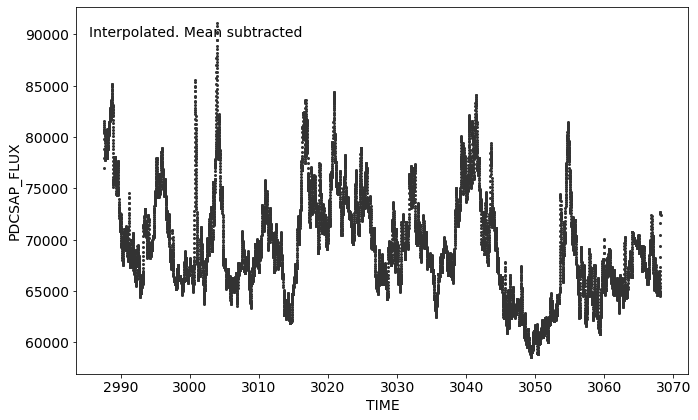

The M value is : 0.12063341358801276


<Figure size 432x288 with 0 Axes>

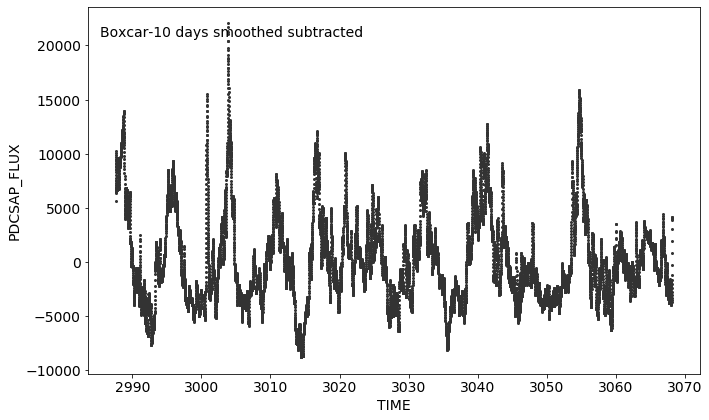

<Figure size 432x288 with 0 Axes>

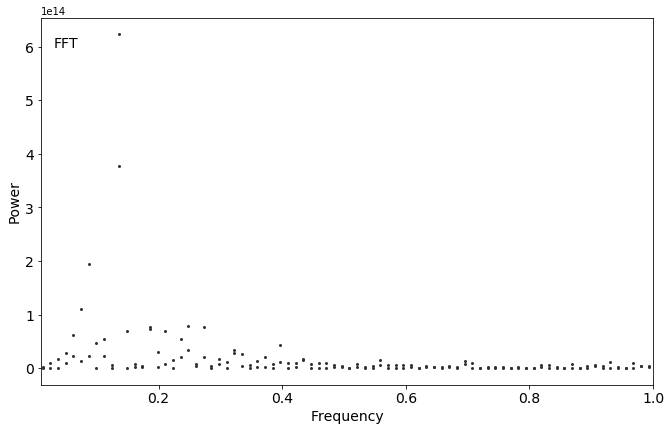

Found periods derived using FFT :  7.32386363625706 +/- -1.3407530684223454


<Figure size 432x288 with 0 Axes>

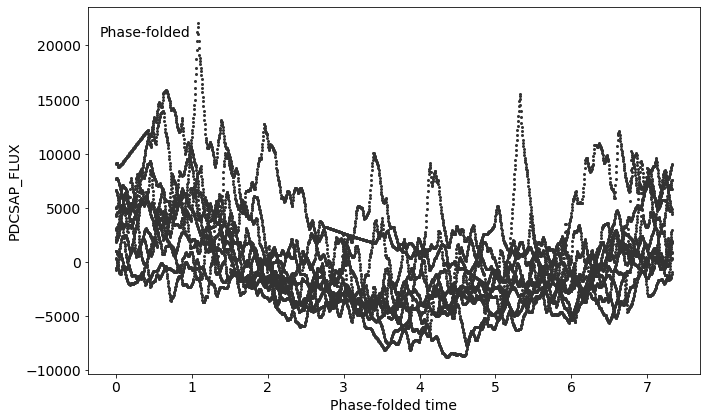

<Figure size 432x288 with 0 Axes>

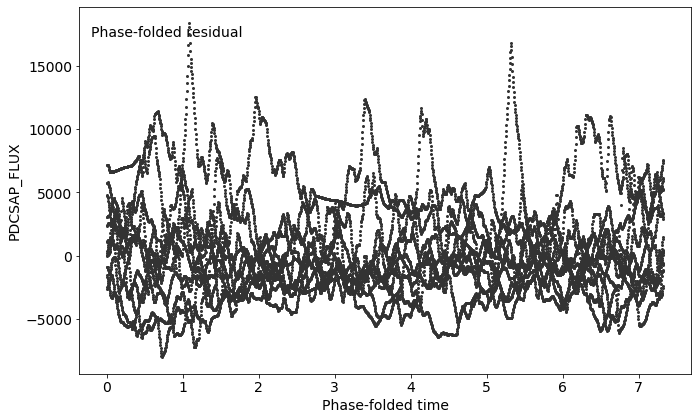

The Q value is : 0.6540819544906489


<Figure size 432x288 with 0 Axes>

In [4]:
source_name = 'dmtau_'

# Load data and plot a preview
dmtau = lightcurve(filename = '../DATA/K2/DM-Tau_1.csv',
                      time_col_label='TIME',
                      data_col_label='PDCSAP_FLUX',
                      plot_preview=False,
                      previewfig_name=source_name + 'input.pdf',
                      verbose=True
                     )

# dmtau.data = np.log10(dmtau.data)

# interpolating data on regular time grid (following Cody+14 to use 6 mins grid)
time_grid = np.arange(dmtau.mintime, dmtau.maxtime, 6.0 * (1.0/(24.0*60.0) )  )
dmtau.interpolate(time_grid = time_grid,
                     plot_preview=False,
                     previewfig_name=source_name + 'interpolate.pdf'
                    )
dmtau.data_plot = dmtau.data
dmtau.time_plot = dmtau.time


# subtract mean value from the data
# --- comment: unsatisfied. Try removing polynomial
dmtau.data = dmtau.data - np.mean(dmtau.data)
dmtau.plotdata(source_name + 'interpolate_meansubtracted.pdf', 
                 label='Interpolated. Mean subtracted')

##### Steps for derving M parameter #######################################################

smoothed_data = dmtau.boxcar_smooth(boxsize=2.0/24.0)
dmtau.data_plot = dmtau.data - smoothed_data
dmtau.get_M(sigma_clip=5.0)
print('The M value is :', dmtau.M)

##### Steps for derving period and Q parameter ############################################

# Following Cody et al. (2014) to subtract boxcar-smoothed version with a window of 10 days
smoothed_data = dmtau.boxcar_smooth(boxsize=10.0)
dmtau.data_plot = dmtau.data - smoothed_data
dmtau.plotdata(source_name + 'boxcar_subtracted.pdf', 
                 label='Boxcar-10 days smoothed subtracted')

# satisfied with subtraction. Apply to actual data
dmtau.data = dmtau.data_plot

# performing fft
dmtau.fft(plot_preview=True, previewfig_name=source_name + 'FFT.pdf', xlim=[0.01,1.0])

# Obtaining the period using the FFT method
dmtau.get_period(method='fft')

# Phase-folding data
# dmtau.period = 7.355520000000001  # The value used by Terada
dmtau.phase_fold(plot_preview=True, previewfig_name=source_name + 'phasefold.pdf')

# residual
dmtau.phase_fold(residual=True, timebin=0.1, plot_preview=True, 
                    previewfig_name=source_name + 'phasefold_residual.pdf')

# evaluate Q value
dmtau.get_Q(sigma=0.0, timebin=0.05)
print('The Q value is :', dmtau.Q)

### Fine-tuning the period by minimizing Q. This is qualitatively similar with doing auto-correlation.

In [8]:
# Find the minimum possible Q
Q_list      = []
period_list = []
for period in np.arange(7.1, 7.4, 0.001):
    dmtau.period = period
    dmtau.get_Q(sigma=0.0, timebin=0.05)
    Q_list.append(dmtau.Q)
    period_list.append(period)
    
print('The minimum Q of DM Tau is :', np.min( np.array(Q_list) ) )
index = ( Q_list == np.min( np.array(Q_list) ) )
print('The period is', round(np.array(period_list)[index][0], 3) )

The minimum Q of DM Tau is : 0.640799857396101
The period is 7.373


### Examning phase folding with the best-fit phase value

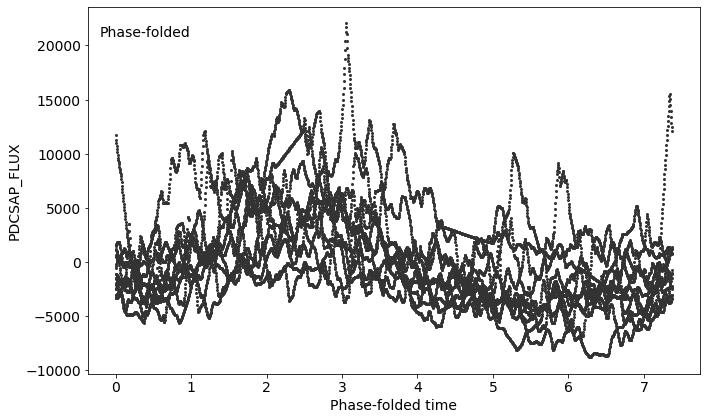

<Figure size 432x288 with 0 Axes>

In [9]:
dmtau.period   = round(np.array(period_list)[index][0], 3)
dmtau.phase_fold(plot_preview=True, previewfig_name=source_name + 'bestphasefold.pdf')